In [35]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

close = pd.read_csv("close_data.csv")

close.index = pd.to_datetime(close['Date'], format='%Y-%m-%d')
close = close.drop('Date', axis=1)
close

,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2024-02-21,181.463181,168.589996,409.250000,142.035110,153.747635,466.743652,399.132782,67.452881,194.770004,274.710510
2024-02-22,183.503525,174.580002,415.160004,143.569534,155.462631,484.793915,408.531006,78.515747,197.410004,281.648743
2024-02-23,181.662216,174.990005,417.220001,143.440033,156.809418,482.699707,407.230957,78.794655,191.970001,281.499847
2024-02-26,180.308624,174.729996,409.140015,137.073105,155.792053,480.415955,404.452179,79.069588,199.399994,282.045776
2024-02-27,181.771698,173.539993,408.910004,138.378372,155.976166,485.711365,404.392609,78.678688,199.729996,281.073029
...,...,...,...,...,...,...,...,...,...,...
2025-02-14,244.600006,228.679993,479.589996,185.229996,154.910004,736.669983,407.612671,138.850006,355.839996,353.809998
2025-02-18,244.470001,226.649994,482.820007,183.770004,154.990005,716.369995,408.820282,139.399994,354.109985,356.730011
2025-02-19,244.869995,226.630005,483.769989,185.270004,157.889999,703.770020,413.940002,139.229996,360.559998,355.230011


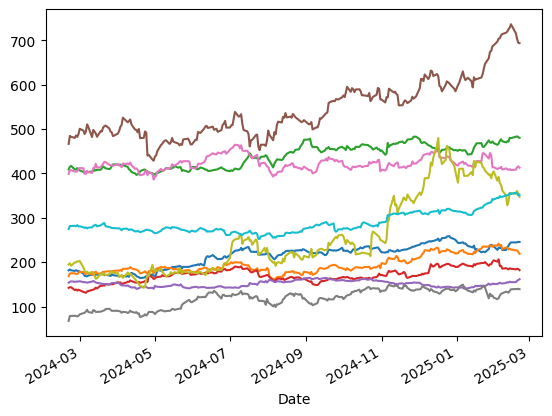

In [36]:
stock_to_use = 'AAPL'
stocks = ['AAPL', 'AMZN', 'BRK-B', 'GOOGL', 'JNJ', 'META', 'MSFT', 'NVDA', 'TSLA', 'V']
stock_data = []
for i in stocks:
    stock_data.append(close[i])
    close[i].plot()

#stock = close[stock_to_use]
#stock.plot()

In [37]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 5

X1 = np.array([])
y1 = np.array([])
for i in stock_data:
  X_temp, y_temp = df_to_X_y(i, WINDOW_SIZE)
  X1 = list(X1) + list(X_temp)
  y1 = np.concatenate((y1, y_temp))

#X1, y1 = df_to_X_y(stock, WINDOW_SIZE) ((247, 5, 1), (247,))
X1 = np.array(X1)
y1 = np.array(y1)
X1.shape, y1.shape


((2470, 5, 1), (2470,))

In [38]:
X_train1, y_train1 = X1[:1500], y1[:1500]
X_val1, y_val1 = X1[1500:2000], y1[1500:2000]
X_test1, y_test1 = X1[2000:], y1[2000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1500, 5, 1), (1500,), (500, 5, 1), (500,), (470, 5, 1), (470,))

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [41]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=15, callbacks=[cp1])

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 100467.1016 - root_mean_squared_error: 316.8171 - val_loss: 53020.9492 - val_root_mean_squared_error: 230.2628
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48447.0430 - root_mean_squared_error: 219.6991 - val_loss: 22674.0625 - val_root_mean_squared_error: 150.5791
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22956.7031 - root_mean_squared_error: 151.4431 - val_loss: 19930.3477 - val_root_mean_squared_error: 141.1749
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19123.1680 - root_mean_squared_error: 137.8849 - val_loss: 4638.3223 - val_root_mean_squared_error: 68.1052
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5165.5327 - root_mean_squared_error: 71.2270 - val_loss: 520.1272 - val_root_mean_squared_error: 22.8063
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1498.4965 - root_mean_squared_error: 38.6754 - val_loss: 242.2730 - val_root_mean_squared_error: 15.5651
Epo

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'model1/best_model.keras'
cp1 = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [43]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Train Predictions,Actuals
0,185.365677,180.567383
1,183.968033,179.900528
2,183.275894,178.815674
3,182.466827,174.277084
4,178.153503,169.320496
...,...,...
1495,409.150757,414.158051
1496,409.871368,418.217102
1497,412.878693,422.008148
1498,414.657623,426.116760


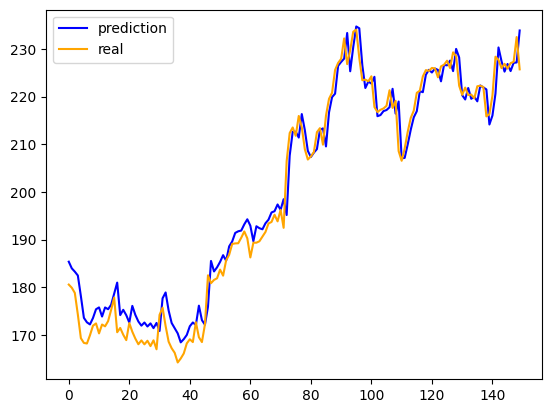

In [44]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:150], color='blue', label='prediction')
plt.plot(train_results['Actuals'][:150], color='orange', label='real')
plt.legend()
plt.show()


259.3209432704623


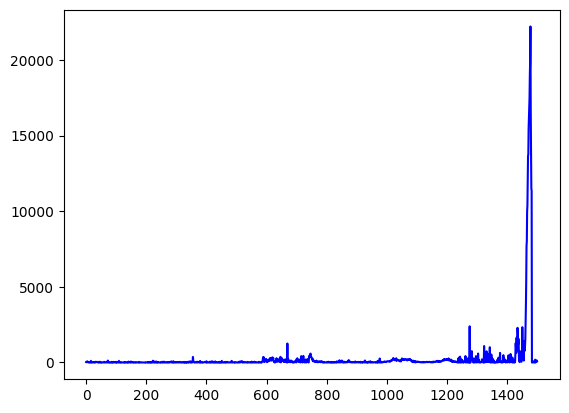

In [45]:
plt.plot(np.abs(train_results['Train Predictions'][:]-train_results['Actuals'][:])**2, color='blue', label='prediction')
print(np.mean(np.abs(train_results['Train Predictions'][:]-train_results['Actuals'][:])**2))